In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
    
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : SVnkSMSI 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

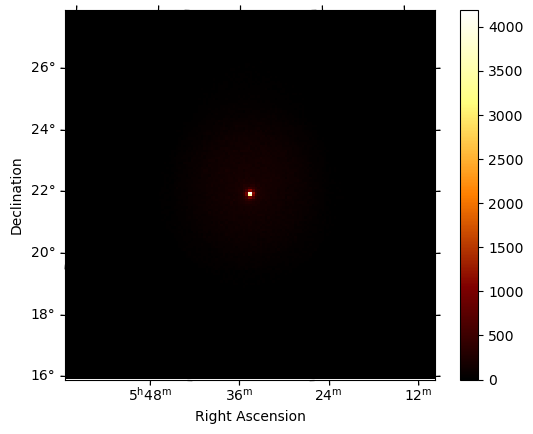

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [9]:
shift = +0.085
tilt = 0.015


N = 47
sigma_a = shift
sigma_i = tilt

save = True
save_flux = True




In [10]:
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass


0
shift:, [0.0374606], tilt: [0.01841008]
1.0617505972550134e-12   1.0729773673810715e-13   2.296103394320044   0.05821922382228519   0.9980066026965007   0.002067737816262989   -0.0019138514870187446   0.0019603510923744817   
index
amplitude
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.692155530742859 1.0637947195602135
norm 0.9060423433853638 0.3940239375779769
norm 0.9023020196654136 0.19552754899186645
norm 1.0546183484455358 0.1749937999703145
norm 0.9985851791248181 0.17293852804270438
norm 0.9034463451261836 0.17942911970830386
norm 1.155152950968298 0.20238592657770485
norm 1.0247099448082644 0.21264507867390783
norm 0.7279807014503324 0.2065087026479995
norm 1.322094953432721 0.2719471459619854
norm 1.2423320647120657 0.30108238019420497
norm 1.0078474031200302 0.31291866023338444
norm 1.1422202036908922 0.36582864070045323
norm 1.0060273830857196 0.4029927227230077
norm 0.2616216690638879 0.3356052055910301
norm 1.31802972183516 0.5601684469700408
norm 0.713

norm 0.6727315149007721 0.18287598527724758
norm 1.2572403230007565 0.22076942605836697
norm 1.1778567287262207 0.24893034229635702
norm 1.3414210107290385 0.29506447886072945
norm 0.285967020917962 0.2518571694445308
norm 1.0783813513401266 0.35112739340176996
norm 0.5771968186273766 0.3466528394371748
norm 1.5955218319456088 0.5077490070236398
norm 0.5319073559261482 0.4320916861680404
norm 1.0415782509072267 0.6141731486450913
norm 1.0016739790542266 0.7598311327968289
norm 1.0 0
8
shift:, [-0.11168158], tilt: [-0.01112437]
7.686435374335613e-13   8.276507546397032e-14   2.1939802076444446   0.06498295706193767   1.0007292200561742   0.002065996558483035   0.0008089999388683506   0.0019612439430604627   
index
amplitude
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2195892230234 1.5467385394329944
norm 0.6987471254281885 0.5264930567187517
norm 1.0500677450102072 0.2735579652834559
norm 0.8285336520795715 0.22111517072537787
norm 1.110581739048731 0.22267471476149464

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6297662826604644 1.123580639991644
norm 1.0336082723492677 0.4356963203135163
norm 0.9460593511538113 0.2180037259976792
norm 1.0846804967081827 0.1917588909286721
norm 0.9686293565421895 0.18505701576347128
norm 1.0781821978631565 0.19462299147917905
norm 1.2671505582449458 0.21032218692158774
norm 0.8841878745155075 0.21175829800754997
norm 0.6731045291440876 0.21238854142341917
norm 0.9104132493761452 0.25427499354222405
norm 0.8899621314475212 0.28289173452756666
norm 0.7706715687726418 0.30055817666683476
norm 0.7889169957520036 0.3312190094724598
norm 1.0882071034591958 0.41967048577421795
norm 1.161681848962381 0.45937878517658104
norm 1.1304742354639963 0.5396746971718367
norm 1.4681367221508699 0.6900897608428816
norm 2.0764748909724458 0.9351144875483043
norm 1.0 0
16
shift:, [-0.00877272], tilt: [-0.00748913]
1.0450507998387447e-12   9.24598525030668e-14   2.3880608534550123   0.06716260403576821   1.001284930826663   0.0020

norm 0.53272093576701 0.4196897400923271
norm 1.3895743544799855 0.6531903454956353
norm 1.6409165941679287 0.6923334111452957
norm 0.09467538811117883 0.4541368739340478
norm 1.4329578700428915 0.9645358444819652
norm 1.0 0
23
shift:, [-0.00244989], tilt: [0.00679608]
1.0945950899681813e-12   9.0674426890325e-14   2.2902817310527213   0.056825496642836995   0.9994426806869534   0.0020652300214914214   -0.0008510305043533837   0.001960495648861432   
index
amplitude
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3018653826744386 0.9845599207888225
norm 1.2511365385151716 0.37605776809828445
norm 0.9923344698297032 0.19255329549726904
norm 0.8193908293665829 0.16175073275352858
norm 1.0452600003200194 0.1668982741767895
norm 1.0374234644848412 0.17902768984079706
norm 1.1271404258724742 0.1865834818170822
norm 0.7568331266622546 0.18664789857950842
norm 1.1856560265778933 0.22424234836748505
norm 0.8949128702667732 0.2293038834639274
norm 1.218469862384645 0.2865504334935

norm 1.6494485596898996 0.46797931665842907
norm 1.196852264699105 0.22859081276714496
norm 0.908686180860857 0.19315908220630146
norm 0.6933909433911944 0.18948187988833548
norm 1.1140461039764376 0.213129316210192
norm 0.9662519167175873 0.22120372790156548
norm 0.7264087179891949 0.23536510182826692
norm 1.4574648759637354 0.2941759005906555
norm 1.4148954940543805 0.33519059220869624
norm 0.8794506978268192 0.3315893122501215
norm 0.42544057931454776 0.318870223943092
norm 0.4273574221395256 0.37247260374327373
norm 1.7275620908674347 0.6183136110432826
norm 0.8922433013226957 0.5406994400628126
norm 1.7174802493304404 0.8198781085604063
norm 1.0990912150573338 0.7597745344256086
norm 0.6705369958485519 0.9154666208430914
norm 1.0 0
31
shift:, [0.05401262], tilt: [0.01447028]
1.0368093693573262e-12   8.91521922795106e-14   2.3098119102937753   0.059538810623477254   0.9993586244174874   0.002064959238828621   0.0002596344144404086   0.0019620392201370727   
index
amplitude
norm 1.0

norm 1.474206685404264 0.517264080730893
norm 1.6992054132417291 0.7111003421912067
norm 1.5096830926433786 0.6827608039466767
norm 1.060062359430233 0.7076753886918625
norm 1.0 0
38
shift:, [0.1381891], tilt: [0.01459258]
1.1555726748155052e-12   9.371701154534207e-14   2.336212997105047   0.05944505006815852   1.0014698823708033   0.0020679920965136875   0.0001837114099717466   0.001960829910011953   
index
amplitude
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7902684700817163 0.8673459773032322
norm 1.0633917837818483 0.3671732928168036
norm 1.1842255920083127 0.188743237885456
norm 0.8689789447002091 0.15447475208078743
norm 1.1160632749393578 0.1656693477895492
norm 0.795606666005915 0.16152877436269308
norm 1.0558539683355257 0.18517811933910164
norm 0.8163790715234588 0.19295504746324602
norm 1.050504496659193 0.2212416144042658
norm 1.3189210159170548 0.2634590143917032
norm 0.9449984122307303 0.27278779328066827
norm 0.7757512236465285 0.3009754146549017
norm

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1.1283968976718906e-12   9.22716046385543e-14   2.349967956438272   0.05999119468721204   0.9967781705956782   0.0020623417942913108   -0.002543166062566427   0.0019604838078237986   
index
amplitude
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.4248321123796739 0.7391746142429538
norm 0.8316068131221079 0.35882003699482556
norm 1.0586072815163714 0.18903475242509007
norm 1.0794233606693777 0.16379200653476675
norm 1.0959886996782666 0.16747467608289276
norm 0.8102700674090164 0.16558423616487972
norm 1.049740864264005 0.19252020321148014
norm 0.8308200688714862 0.19815459270699826
norm 1.300231603849467 0.238990408578206
norm 1.0972355715324278 0.26932775262809266
norm 1.193595702085146 0.3028512385861818
norm 0.9003506859304222 0.31420554060069655
norm 0.618910996299592 0.3370994028964383
norm 0.41747302316298734 0.3467316507251808
norm 1.3398182750239886 0.5241815194735573
norm 0.8220712487974277 0.5227551098509384
norm 1.1033667443769912 0.7609473546207368
norm 1.4